# Q2 - Top 3 Cities

* For each country, compute the top 3 cities with best air quality and the top 3 cities with poorest air quality, updated weekly, i.e., averaged over a week (7 days).

**Requirement**: Solve this question using Spark Core, Spark Dataframes and Spark SQL.

In [1]:
# @title Mount Google Drive (Optional)
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# @title Download the data for the exercise
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-01.csv' day_1.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-02.csv' day_2.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-03.csv' day_3.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-04.csv' day_4.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-05.csv' day_5.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-06.csv' day_6.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-07.csv' day_7.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-08.csv' day_8.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-09.csv' day_9.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-10.csv' day_10.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-11.csv' day_11.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-12.csv' day_12.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-13.csv' day_13.csv
!cp '/content/drive/MyDrive/2020-01/sds011-2020-01-14.csv' day_14.csv
!wget -q -O sensors_all.json 'https://raw.githubusercontent.com/smduarte/spbd-2223/main/proj/sensors_all.json'

In [3]:
!wc day_1.csv # Check csv has been loaded without troubles
!wc day_2.csv
!wc day_3.csv
!wc day_4.csv
!wc day_5.csv
!wc day_6.csv
!wc day_7.csv

  3290317   3290317 194835673 day_1.csv
  3256573   3256573 191978621 day_2.csv
  3231994   3231994 188195018 day_3.csv
  3294881   3294881 191078779 day_4.csv
  3322904   3322904 193476881 day_5.csv
  3224703   3224703 188613612 day_6.csv
  3249455   3249455 190604169 day_7.csv


In [4]:
!wc sensors_all.json # Check json has been uploaded correctly

      0    4119 1548915 sensors_all.json


In [5]:
# @title Install Pyspark
!pip install --quiet pyspark

     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 199 kB 72.9 MB/s 


In [6]:
!cp '/content/day_1.csv' week_metrics.csv
!cat '/content/day_2.csv' >> week_metrics.csv
!cat '/content/day_3.csv' >> week_metrics.csv
!cat '/content/day_4.csv' >> week_metrics.csv
!cat '/content/day_5.csv' >> week_metrics.csv
!cat '/content/day_6.csv' >> week_metrics.csv
!cat '/content/day_7.csv' >> week_metrics.csv
!cat '/content/day_8.csv' >> week_metrics.csv
!cat '/content/day_9.csv' >> week_metrics.csv
!cat '/content/day_10.csv' >> week_metrics.csv
!cat '/content/day_11.csv' >> week_metrics.csv
!cat '/content/day_12.csv' >> week_metrics.csv
!cat '/content/day_13.csv' >> week_metrics.csv
!cat '/content/day_14.csv' >> week_metrics.csv

In [7]:
import pandas as pd

df = pd.read_csv("week_metrics.csv", sep=";", header=None)
df.fillna(0, inplace=True)
df.to_csv("week_metrics.csv", sep=";", index=False, header=False)

In [10]:
import pyspark
from operator import *
import numpy as np
import pandas as pd
import json


def mean(values):
    sum_float = sum([val[2] for val in values])
    count = len(values)
    return sum_float / count


sc = pyspark.SparkContext("local[*]")
try:
    # We strip the file in order to be able to treat each line
    sensor_data = sc.textFile("week_metrics.csv").map(lambda line: line.strip())

    # Split country in lines to get the values we need (sensor_id, country, city)
    countries = (
        sc.textFile("sensors_all.json")
        .map(lambda x: (json.loads(x)))
        .flatMap(lambda x: x)
        .map(lambda val: (val["sensor_id"], val["country"], val["city"]))
        .map(lambda key_value: (key_value[0], (key_value[1], key_value[2])))
    )
    # Get the minimum over the first week
    sensors_over_week = (
        sensor_data.map(lambda line: line.split(";"))
        .filter(lambda values: len(values) == 7)
        .map(lambda values: (values[0], values[4][8:10], float(values[6])))
        .groupBy(lambda values: (values[0], int(values[1]) // 7))
        .map(lambda val: (val[0], list(val[1])))
        .map(lambda kv: (kv[0], kv[1]))
        .mapValues(mean)
        .reduceByKey(add)
    )

    sensors_over_week = sensors_over_week.map(
        lambda values: (values[0][0], (values[0][1], values[1]))
    ).reduceByKey(lambda x, y: x)

    countries_sensors = sensors_over_week.join(countries)

    # We compute the top 3 cities by considering that the minimum value will give us the best city
    best_top3 = (
        countries_sensors.map(
            lambda values: (
                values[1][1][0],
                values[1][1][1],
                values[1][0][0],
                values[1][0][1],
            )
        )
        .groupBy(lambda vals: (vals[0], vals[2]))
        .map(lambda x: (x[0], sorted(x[1], key=lambda y: y[3], reverse=False)[:3]))
        .reduceByKey(lambda x, y: x)
        .sortByKey()
    )

    sensors_over_week = (
        sensor_data.map(lambda line: line.split(";"))
        .filter(lambda values: len(values) == 7)
        .map(lambda values: (values[0], values[4][8:10], float(values[5])))
        .groupBy(lambda values: (values[0], int(values[1]) // 7))
        .map(lambda val: (val[0], list(val[1])))
        .map(lambda kv: (kv[0], kv[1]))
        .mapValues(mean)
        .reduceByKey(add)
    )

    sensors_over_week = sensors_over_week.map(
        lambda values: (values[0][0], (values[0][1], values[1]))
    ).reduceByKey(lambda x, y: x)

    countries_sensors = sensors_over_week.join(countries)

    # We compute the top 3 cities by considering that the minimum value will give us the best city
    worst_top3 = (
        countries_sensors.map(
            lambda values: (
                values[1][1][0],
                values[1][1][1],
                values[1][0][0],
                values[1][0][1],
            )
        )
        .groupBy(lambda vals: (vals[0], vals[2]))
        .map(lambda x: (x[0], sorted(x[1], key=lambda y: y[3], reverse=True)[:3]))
        .reduceByKey(lambda x, y: x)
        .sortByKey()
    )

    # We print the results
    print("The Best Cities Are:")
    for city in best_top3.take(10):
        print(
            f"""
    From Country {city[0][0]} and week {city[0][1]} the top cities are
    {city[1][0][1]}, {city[1][1][1]} and {city[1][2][1]} and the values are
    {city[1][0][3]}, {city[1][1][3]} and {city[1][2][3]}"""
        )

    print("The Worst Cities Are:")
    for city in worst_top3.take(10):
        print(
            f"""
    From Country {city[0][0]} and week {city[0][1]} the worst cities are
    {city[1][0][1]}, {city[1][1][1]} and {city[1][2][1]} and the values are
    {city[1][0][3]}, {city[1][1][3]} and {city[1][2][3]}"""
        )

    sc.stop()
except Exception as e:
    print(e)
    sc.stop()

The Best Cities Are:

    From Country France and week 0 the top cities are
    Sargé-lès-le-Mans, Tournus and Bouguenais and the values are
    0.4481695626123432, 1.3271004184100483 and 1.45

    From Country France and week 1 the top cities are
    Rennes, Lannion and Saint-Grégoire and the values are
    1.211360902255639, 1.214228769497397 and 1.2438514851485145

    From Country France and week 2 the top cities are
    Arnouville, La Chapelle-Janson and Valenciennes and the values are
    0.07271626297577906, 0.811574585635359 and 1.4735094339622654

    From Country Germany and week 0 the top cities are
    Stuttgart, Lage and Wardenburg and the values are
    0.0, 0.001227758007117438 and 0.0024377224199288263

    From Country Germany and week 1 the top cities are
    Willingen, Eurasburg and Gladbeck and the values are
    0.014534145722264673, 0.01623392992185542 and 0.01800104794341113

    From Country Germany and week 2 the top cities are
    Schwelm, Frechen and Bergedor

## SPARK DATAFRAMES


The Best Cities Are:
+-------+------------------+----+-------------------+----+
|country|              city|week|              value|rank|
+-------+------------------+----+-------------------+----+
| France|        Arnouville|   0| 0.1462002341920373|   1|
| France| Sargé-lès-le-Mans|   0| 0.4481695626123426|   2|
| France|            Rennes|   0| 1.0088286913391835|   3|
| France|        Arnouville|   1|0.08563114330056895|   1|
| France| Sargé-lès-le-Mans|   1|   0.43509755495184|   2|
| France|La Chapelle-Janson|   1| 0.8844030507480202|   3|
| France|        Arnouville|   2|0.07271626297577848|   1|
| France| Sargé-lès-le-Mans|   2| 0.4286086956521739|   2|
| France|La Chapelle-Janson|   2| 0.8115745856353592|   3|
+-------+------------------+----+-------------------+----+
only showing top 9 rows



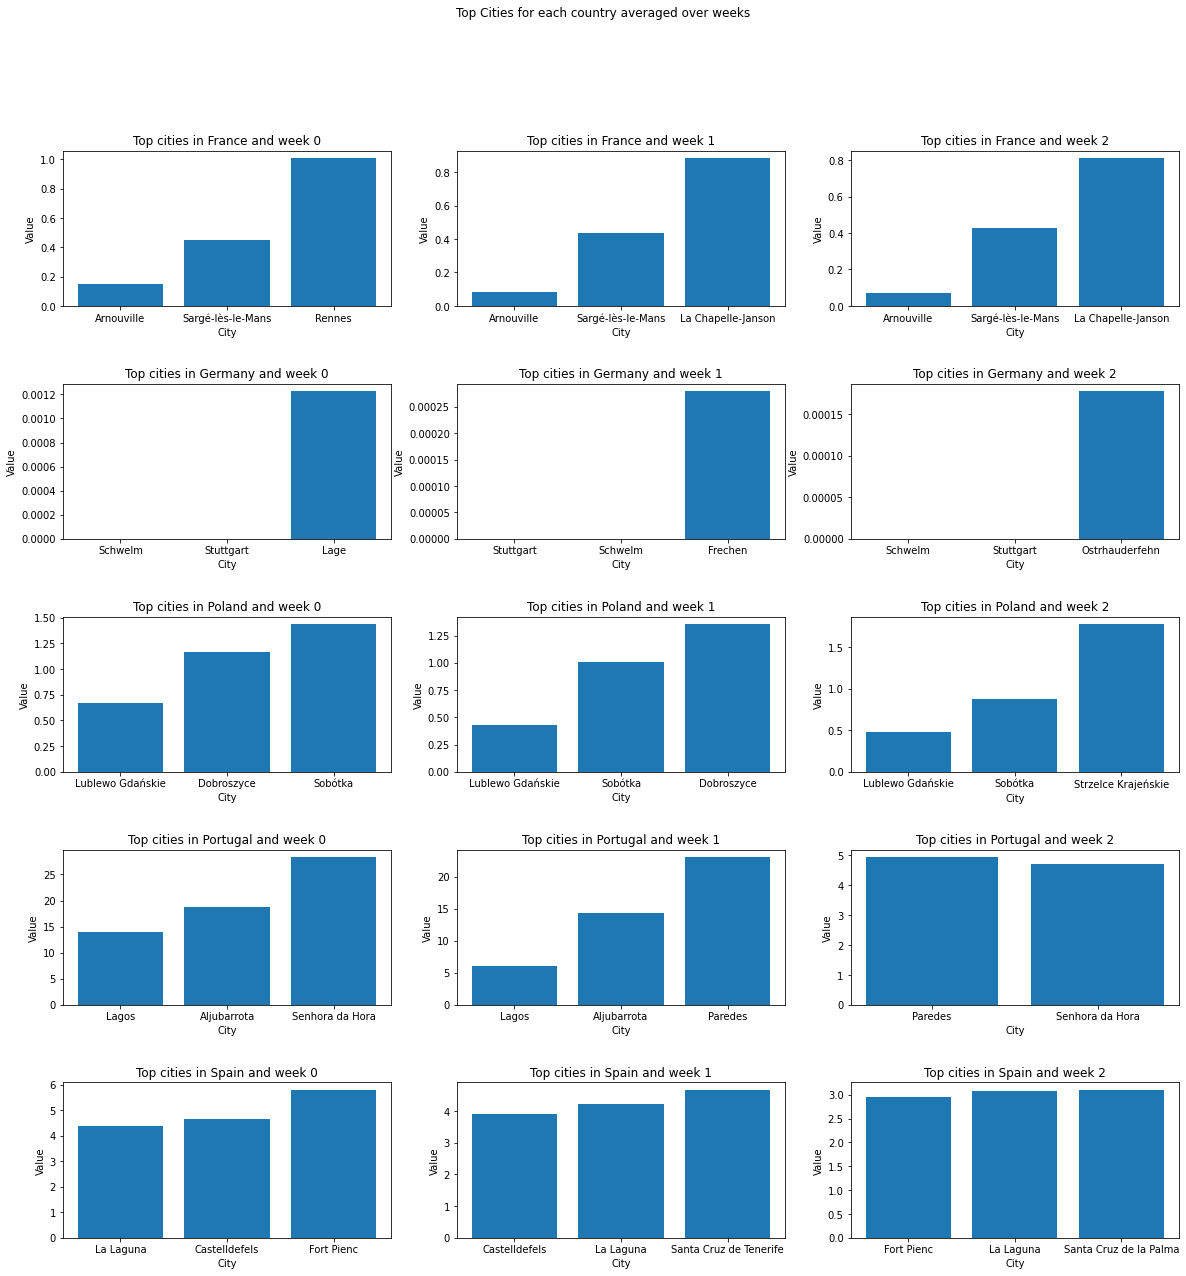

The Worst Cities Are:
+-------+----------+----+------------------+----+
|country|      city|week|             value|rank|
+-------+----------+----+------------------+----+
| France|    Luitré|   0| 797.9404536261186|   1|
| France|    Velaux|   0|117.53061464850934|   2|
| France|La Tronche|   0|41.173026886383354|   3|
| France|    Luitré|   1| 999.8999999999986|   1|
| France|    Anglet|   1|  88.6280668862427|   2|
| France|    Velaux|   1| 77.32363700564972|   3|
| France|    Luitré|   2| 999.8999999999988|   1|
| France|    Anglet|   2|111.90923344947736|   2|
| France|La Tronche|   2|  37.4946273830156|   3|
+-------+----------+----+------------------+----+
only showing top 9 rows



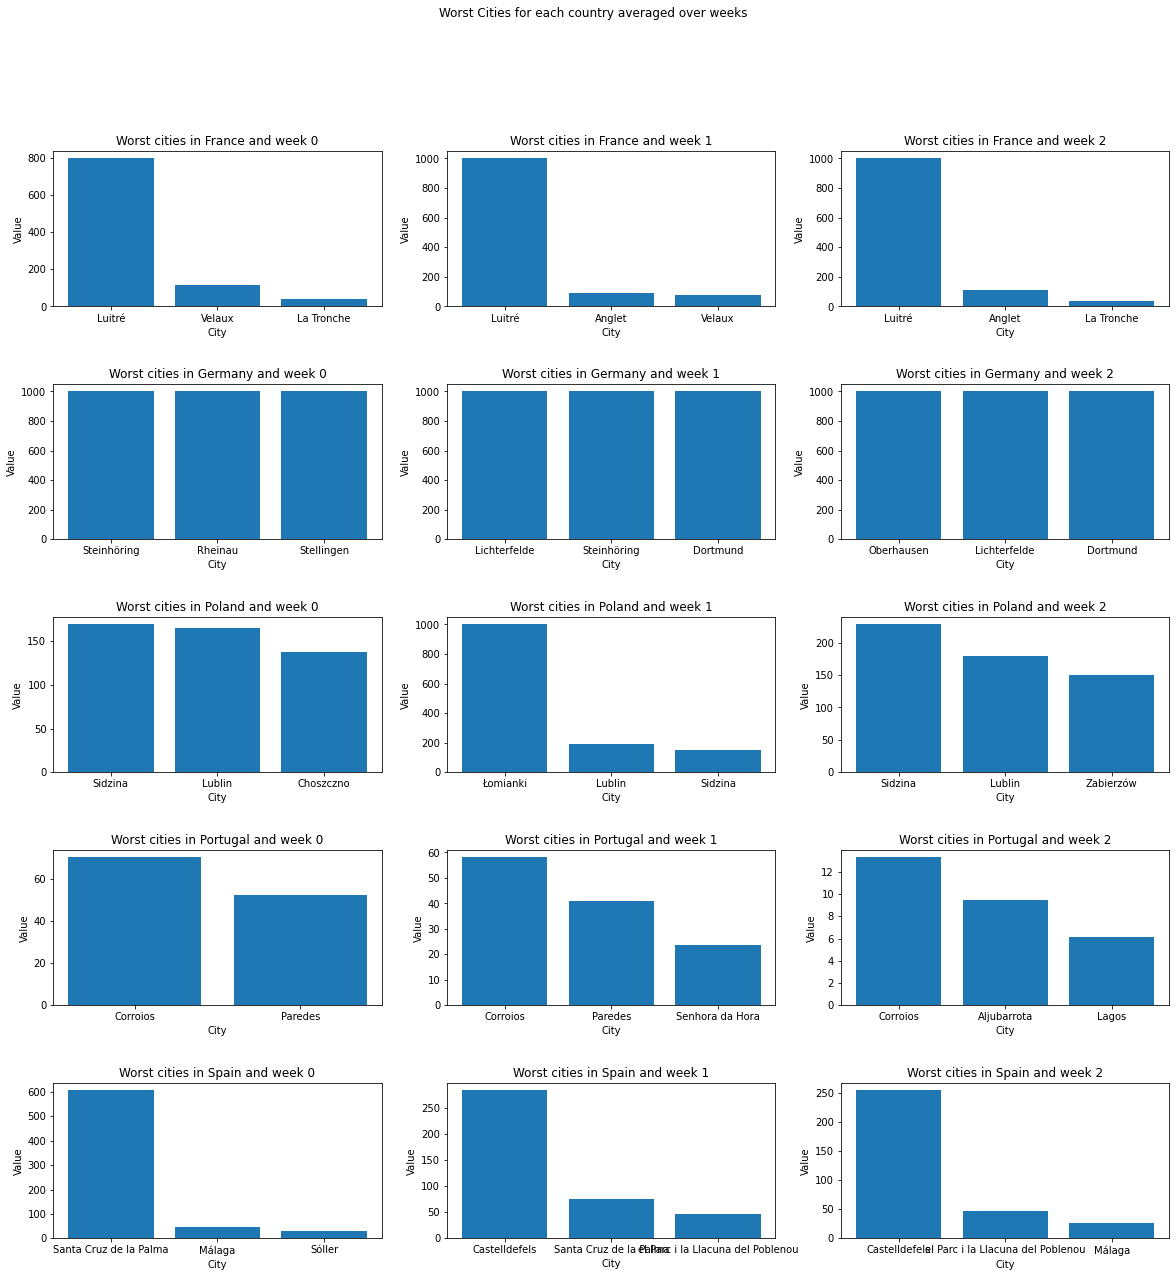

In [28]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import json
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.master("local[*]").appName("Q2_Dataframes").getOrCreate()

sc = spark.sparkContext
try:
    # We strip the file in order to be able to treat each line
    sensor_data = sc.textFile("week_metrics.csv").map(lambda line: line.strip())

    # Split country in lines to get the values we need (sensor_id, country, city)
    countries = (
        sc.textFile("sensors_all.json")
        .map(lambda x: (json.loads(x)))
        .flatMap(lambda x: x)
        .map(lambda val: (val["sensor_id"], val["country"], val["city"]))
        .map(
            lambda key_value: Row(
                sensor_id=key_value[0], country=key_value[1], city=key_value[2]
            )
        )
    )

    # We build the needed dataframes to compute the top3 cities
    countries_dataframe = spark.createDataFrame(countries)
    sensors_over_week = (
        sensor_data.map(lambda line: line.split(";"))
        .filter(lambda values: len(values) == 7)
        .map(
            lambda values: Row(
                sensor_id=values[0],
                week=int(values[4][8:10]) // 7,
                val1=float(values[5]),
                val2=float(values[6]),
            )
        )
    )

    sensors_over_week = spark.createDataFrame(sensors_over_week)

    df = sensors_over_week.groupBy(["sensor_id", "week"]).agg(
        mean("val1"), mean("val2")
    )
    countries_sensors = df.join(countries_dataframe, "sensor_id")

    # We first select the fields we want, and then we group by to rank the cities from the best to the worst
    # then we just pick 3 cities per country so we will end up with the dataframe we were aiming to
    best_top3 = (
        countries_sensors.select(
            "country", "city", "week", col("avg(val2)").alias("value")
        )
        .groupBy("country", "city", "week", "value")
        .agg(
            row_number()
            .over(Window.partitionBy(["country", "week"]).orderBy(asc("value")))
            .alias("rank")
        )
        .filter(col("rank") <= 3)
        .orderBy(["country", "week", asc("rank")])
    )

    # We repeat the same, but just to get the worst three cities per country
    worst_top3 = (
        countries_sensors.select(
            "country", "city", "week", col("avg(val2)").alias("value")
        )
        .groupBy("country", "city", "week", "value")
        .agg(
            row_number()
            .over(Window.partitionBy(["country", "week"]).orderBy(desc("value")))
            .alias("rank")
        )
        .filter(col("rank") <= 3)
        .orderBy(["country", "week", asc("rank")])
    )

    print("The Best Cities Are:")
    best_top3.show(9)
    pd_best_t3 = best_top3.toPandas()
    fig, axs = plt.subplots(5, 3, figsize=(20, 20))

    row = 0
    for country in pd_best_t3["country"].unique():
        col = 0
        for week in pd_best_t3["week"].unique():
            cities = pd_best_t3[pd_best_t3["country"] == country]
            cities_per_week = cities[cities["week"] == week]["city"]
            values = pd_best_t3[pd_best_t3["country"] == country]
            values_per_week = values[values["week"] == week]["value"]

            axs[row, col].bar(cities_per_week, values_per_week)
            axs[row, col].set_title(f"Top cities in {country} and week {week}")
            axs[row, col].set_xlabel("City")
            axs[row, col].set_ylabel("Value")

            col += 1
        row += 1

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Top Cities for each country averaged over weeks")
    plt.show()

    print("The Worst Cities Are:")
    worst_top3.show(9)
    pd_worst_t3 = worst_top3.toPandas()
    fig, axs = plt.subplots(5, 3, figsize=(20, 20))

    row = 0
    for country in pd_worst_t3["country"].unique():
        col = 0
        for week in pd_worst_t3["week"].unique():
            cities = pd_worst_t3[pd_worst_t3["country"] == country]
            cities_per_week = cities[cities["week"] == week]["city"]
            values = pd_worst_t3[pd_worst_t3["country"] == country]
            values_per_week = values[values["week"] == week]["value"]

            axs[row, col].bar(cities_per_week, values_per_week)
            axs[row, col].set_title(f"Worst cities in {country} and week {week}")
            axs[row, col].set_xlabel("City")
            axs[row, col].set_ylabel("Value")

            col += 1
        row += 1

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Worst Cities for each country averaged over weeks")
    plt.show()

    sc.stop()
except Exception as e:
    print(e)
    sc.stop()

## SPARK SQL


The Best Cities Are:
+-------+------------------+----+-------------------+
|country|              city|week|              value|
+-------+------------------+----+-------------------+
| France|        Arnouville|   0| 0.1462002341920373|
| France| Sargé-lès-le-Mans|   0| 0.4481695626123426|
| France|            Rennes|   0| 1.0088286913391835|
| France|        Arnouville|   1|0.08563114330056895|
| France| Sargé-lès-le-Mans|   1|   0.43509755495184|
| France|La Chapelle-Janson|   1| 0.8844030507480202|
| France|        Arnouville|   2|0.07271626297577848|
| France| Sargé-lès-le-Mans|   2| 0.4286086956521739|
| France|La Chapelle-Janson|   2| 0.8115745856353592|
+-------+------------------+----+-------------------+
only showing top 9 rows



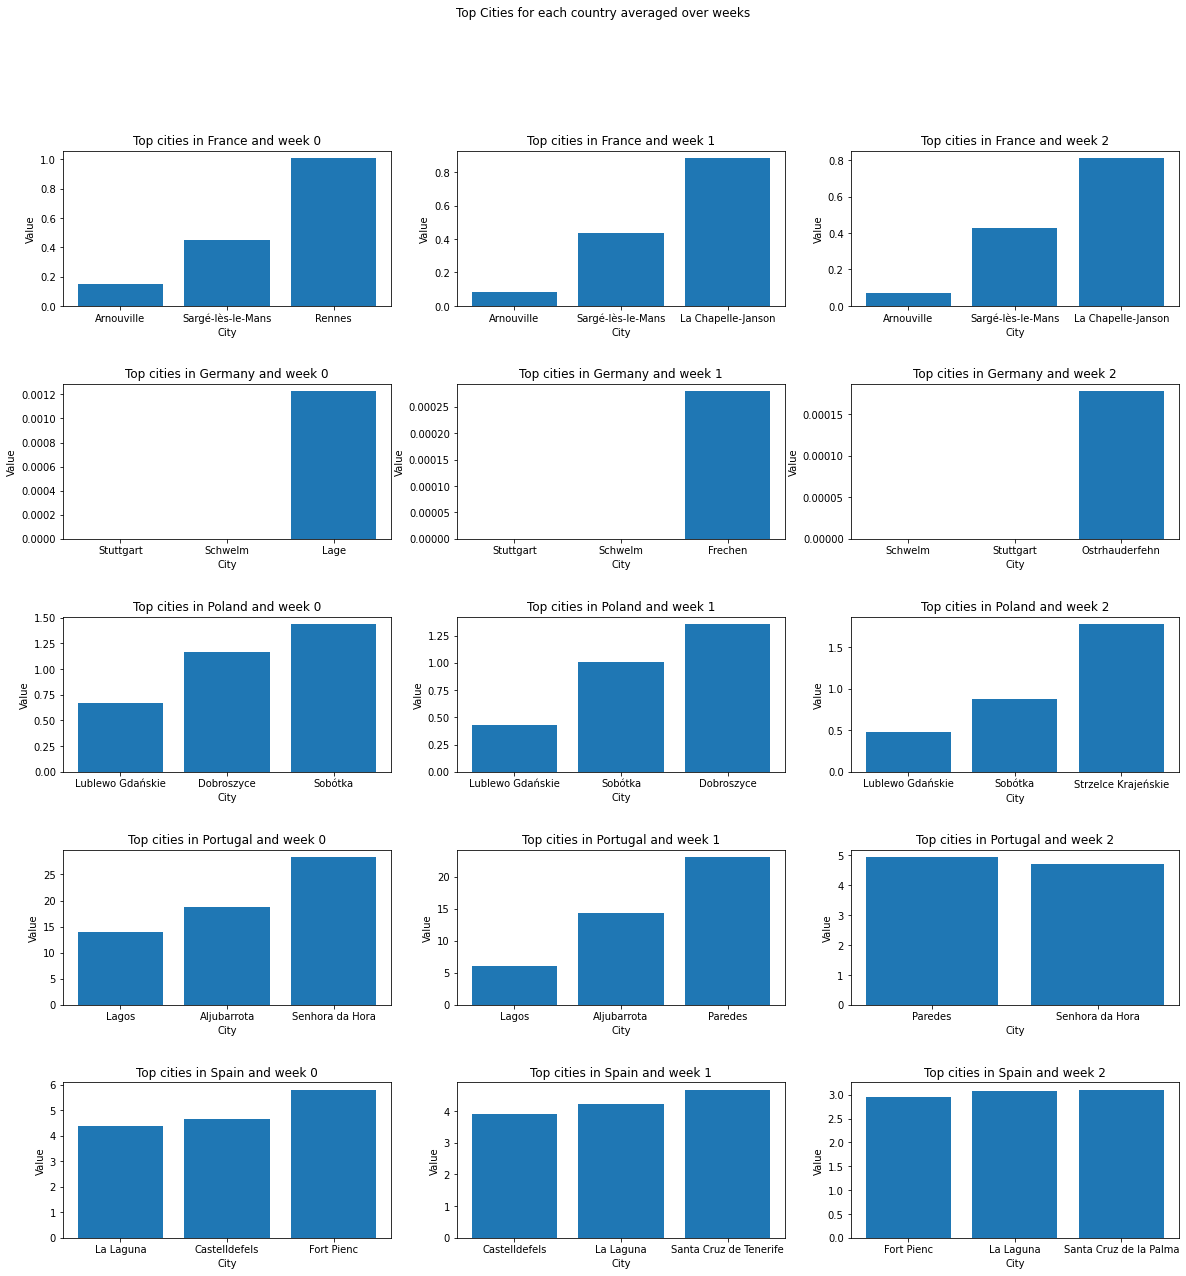

The Worst Cities Are:
+-------+--------------------+----+------------------+
|country|                city|week|             value|
+-------+--------------------+----+------------------+
| France|              Luitré|   0|1617.8132071655564|
| France|              Velaux|   0|  424.922984909827|
| France|          Charnècles|   0|174.56966602440593|
| France|              Luitré|   1|1999.8999999999962|
| France|              Velaux|   1|254.13018361581928|
| France|             Crusnes|   1| 143.0354700854701|
| France|              Luitré|   2|1999.8999999999967|
| France|              Anglet|   2|146.77351916376304|
| France|Bretignolles-sur-Mer|   2| 92.51993091537133|
+-------+--------------------+----+------------------+
only showing top 9 rows



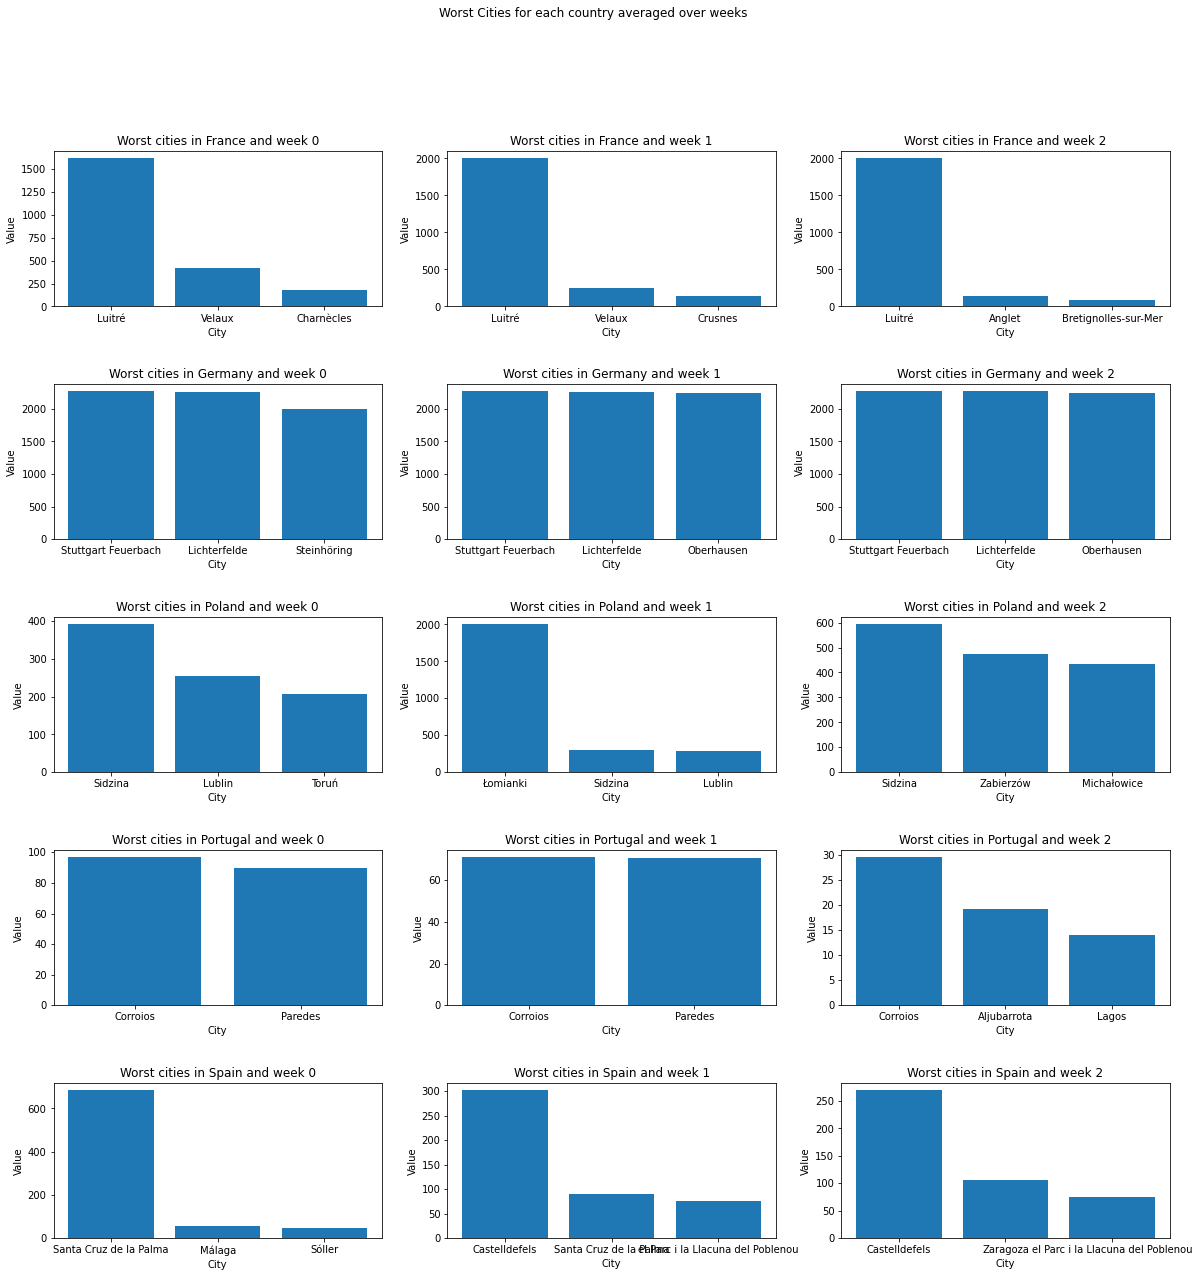

In [30]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *


import json

spark = SparkSession.builder.master("local[*]").appName("Q2_SQL").getOrCreate()

sc = spark.sparkContext
try:
    # We strip the file in order to be able to treat each line
    sensor_data = sc.textFile("week_metrics.csv").map(lambda line: line.strip())

    # Split country in lines to get the values we need (sensor_id, country, city)
    countries = (
        sc.textFile("sensors_all.json")
        .map(lambda x: (json.loads(x)))
        .flatMap(lambda x: x)
        .map(lambda val: (val["sensor_id"], val["country"], val["city"]))
        .map(
            lambda key_value: Row(
                sensor_id=key_value[0], country=key_value[1], city=key_value[2]
            )
        )
    )

    countries_dataframe = spark.createDataFrame(countries)
    sensors_over_week = (
        sensor_data.map(lambda line: line.split(";"))
        .filter(lambda values: len(values) == 7)
        .map(
            lambda values: Row(
                sensor_id=values[0],
                week=int(values[4][8:10]) // 7,
                val1=float(values[5]),
                val2=float(values[6]),
            )
        )
    )
    # Once we have the dataframe we just make a view to operate through sql queries
    sensors_over_week = spark.createDataFrame(sensors_over_week)
    sensors_over_week.createOrReplaceTempView("SensorsOverWeek")

    # We group data by weeks
    weekly_metrics = spark.sql(
        """SELECT sensor_id, week, AVG(val1) as val1, AVG(val2) as val2
                          FROM SensorsOverWeek
                          GROUP BY sensor_id, week
                          """
    )

    # We compute the final view to get the result
    countries_sensors = weekly_metrics.join(countries_dataframe, "sensor_id")
    countries_sensors.createOrReplaceTempView("countries_sensors")

    # We use the ranking system to get the top cities and then get the final results for each case
    best_top3 = spark.sql(
        """
                        SELECT country, city, week, val2 as value
                        FROM (
                          SELECT *, row_number() OVER w AS rn
                          FROM countries_sensors
                          WINDOW w AS (PARTITION BY country, week ORDER BY val2 ASC)
                        )
                        WHERE rn <= 3
                        GROUP BY country, city, week, value
                        ORDER BY country, week, value 
                        """
    )

    worst_top3 = spark.sql(
        """
                        SELECT country, city, week, val1 as value
                        FROM (
                          SELECT *, row_number() OVER w AS rn
                          FROM countries_sensors
                          WINDOW w AS (PARTITION BY country, week ORDER BY val1 DESC)
                        )
                        WHERE rn <= 3
                        GROUP BY country, city, week, value
                        ORDER BY country, week, value DESC
                        """
    )

    print("The Best Cities Are:")
    best_top3.show(9)
    pd_best_t3 = best_top3.toPandas()
    fig, axs = plt.subplots(5, 3, figsize=(20, 20))

    row = 0
    for country in pd_best_t3["country"].unique():
        col = 0
        for week in pd_best_t3["week"].unique():
            cities = pd_best_t3[pd_best_t3["country"] == country]
            cities_per_week = cities[cities["week"] == week]["city"]
            values = pd_best_t3[pd_best_t3["country"] == country]
            values_per_week = values[values["week"] == week]["value"]

            axs[row, col].bar(cities_per_week, values_per_week)
            axs[row, col].set_title(f"Top cities in {country} and week {week}")
            axs[row, col].set_xlabel("City")
            axs[row, col].set_ylabel("Value")

            col += 1
        row += 1

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Top Cities for each country averaged over weeks")
    plt.show()

    print("The Worst Cities Are:")
    worst_top3.show(9)
    pd_worst_t3 = worst_top3.toPandas()
    fig, axs = plt.subplots(5, 3, figsize=(20, 20))

    row = 0
    for country in pd_worst_t3["country"].unique():
        col = 0
        for week in pd_worst_t3["week"].unique():
            cities = pd_worst_t3[pd_worst_t3["country"] == country]
            cities_per_week = cities[cities["week"] == week]["city"]
            values = pd_worst_t3[pd_worst_t3["country"] == country]
            values_per_week = values[values["week"] == week]["value"]

            axs[row, col].bar(cities_per_week, values_per_week)
            axs[row, col].set_title(f"Worst cities in {country} and week {week}")
            axs[row, col].set_xlabel("City")
            axs[row, col].set_ylabel("Value")

            col += 1
        row += 1

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Worst Cities for each country averaged over weeks")
    plt.show()

    sc.stop()
except Exception as e:
    print(e)
    sc.stop()